<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-kawaii-dinosaur-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>MRI Brain Alzheimer Classification - DINOv2 Model</strong>
</h1>

**Clone Dataset from GitHub**

In [1]:
# Clone repository from GitHub
# !git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification

# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Barin_Alzheimer_Classification


**Import Packages**

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
import gc
import subprocess

**Import Internal Functions**

In [3]:
from models import def_models
from utils import utils_funcs
from utils import optuna_search

**Device Definition**

In [4]:
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.memory_summary())
utils_funcs.open_nvitop()

torch.cuda.is_available(): True
device: cuda:0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from larg

**Model Definition and Initialization**

In [5]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# Freeze DINOv2 layers
for param in dino_v2_model.parameters():
    param.requires_grad = False

# Create DINOv2 model with FC layers before the output
model = def_models.DINO_v2_FT(dino_backbone=dino_v2_model, output_channels=output_channels).to(device)

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


**Load Dataset**

In [6]:
# Load the dataset
train_set = torch.load('./dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('./dataset/dataset_variables/test_set.pt')

**Model Statistics**

In [7]:
model_name = type(model).__name__
print("Model", model_name, "statistics:")
summary(model, (input_channels, input_height, input_width))

Model DINO_v2_FT statistics:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
          

**Set Hyper-Parameters Using Optuna**

In [8]:
load_existing_hyperparams = False

if load_existing_hyperparams:
    # Load hyper-parameters (relevant if optuna has already used)
    optuna_params_path = f'./checkpoints/op_tuna_params/{model_name}/DINO_v2_FT_0.8865.json'
    with open(optuna_params_path, 'r') as file:
        hyperparams = json.load(file)
else:
    # Find optimal hyper-parameters using optuna
    hyperparams = optuna_search.optuna_param_search(model_name="DINO_v2_FT", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=10, device=device, transfer_learning=True)

print(hyperparams)

[I 2024-10-05 23:23:47,602] A new study created in memory with name: mri-alzhimer-classification


Optuna is done on device: cuda:0


Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [07:46<00:00, 46.61s/it]
[I 2024-10-05 23:31:34,953] Trial 0 finished with value: 0.8135416666666667 and parameters: {'lr': 6.125800979342132e-06, 'optimizer': 'RMSprop', 'batch_size': 64, 'scheduler': 'StepLR'}. Best is trial 0 with value: 0.8135416666666667.
Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [05:17<00:00, 31.75s/it]
[I 2024-10-05 23:36:54,237] Trial 1 finished with value: 0.8083333333333333 and parameters: {'lr': 5.782691185629487e-06, 'optimizer': 'RMSprop', 'batch_size': 16, 'scheduler': 'StepLR'}. Best is trial 0 with value: 0.8135416666666667.
Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [05:13<00:00, 31.33s/it]
[I 2024-10-05 23:42:09,043] Trial 2 finished with value: 0.7916666666666666 and parameters: {'lr': 3.355616618249038e-06, 'optimizer': 'RM

Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  10
  Number of complete trials:  15
Best trial:
  Value:  0.9072916666666667
  Params: 
    lr: 6.917436540093293e-05
    optimizer: Adam
    batch_size: 64
    scheduler: CosineAnnealingLR
Best parameters saved to checkpoints/op_tuna_params\DINO_v2_FT\DINO_v2_FT_0.9073.json
{'lr': 6.917436540093293e-05, 'optimizer': 'Adam', 'batch_size': 64, 'scheduler': 'CosineAnnealingLR'}


In [9]:
# Set hyper-parameters
batch_size = hyperparams['batch_size']
learning_rate = hyperparams['lr']
optimizer_name = hyperparams['optimizer']
optimizer = getattr(torch.optim, optimizer_name)(model.fc.parameters(), lr=learning_rate)
num_epochs = 35
scheduler = hyperparams['scheduler']
scheduler = StepLR(optimizer, 10, 0.1, verbose=True) if scheduler == "StepLR" else CosineAnnealingLR(optimizer, num_epochs, verbose=True)

criterion = nn.CrossEntropyLoss()

**Data Augmentations**

In [10]:
augmentations = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.1),
    K.RandomVerticalFlip(p=0.1),
    K.RandomRotation(degrees=10, p=0.1),
    K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.1),
    K.RandomBrightness(brightness=(0.8, 1.2), p=0.1),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.1),
    K.RandomGamma(gamma=(0.9, 1.1), p=0.1),
    K.RandomSharpness(p=0.1),
    same_on_batch=False
)

**Create Data Loaders**

In [11]:
# Data loading and shuffling
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

**Train Model**

In [12]:
load_existing_params = False
train_loaded_model = False

if load_existing_params:
    model_path = './checkpoints/DINO_v2_FT_151506_05102024/DINO_v2_FT_173045_05102024_train_0.0364_val_0.1293.pth'
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['net'])
    if(train_loaded_model):
        epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer, scheduler, augmentations, use_amp=True)
else:
    epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer, scheduler, augmentations, use_amp=True)

Created training session directory: ./checkpoints/DINO_v2_FT_015151_06102024
Training model: DINO_v2_FT on cuda:0


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Epoch: 1 | Training Loss: 0.5500 | Training Accuracy: 88.184% | Validation Loss: 0.4212 | Validation Accuracy: 83.740% | Epoch Time: 243.64 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Epoch: 2 | Training Loss: 0.3602 | Training Accuracy: 91.528% | Validation Loss: 0.3808 | Validation Accuracy: 85.693% | Epoch Time: 256.02 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Epoch: 3 | Training Loss: 0.2842 | Training Accuracy: 96.252% | Validation Loss: 0.3321 | Validation Accuracy: 89.648% | Epoch Time: 261.94 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Epoch: 4 | Training Loss: 0.2295 | Training Accuracy: 97.729% | Validation Loss: 0.2854 | Validation Accuracy: 91.064% | Epoch Time: 254.98 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Epoch: 5 | Training Loss: 0.1884 | Training Accuracy: 98.218% | Validation Loss: 0.2739 | Validation Accuracy: 91.650% | Epoch Time: 257.53 secs
==> Saving model ...
Saved as ./checkpoints/DINO_v2_FT_015151_06102024/DINO_v2_FT_021305_06102024_train_0.1884_val_0.2739.pth


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Epoch: 6 | Training Loss: 0.1745 | Training Accuracy: 99.023% | Validation Loss: 0.2344 | Validation Accuracy: 92.969% | Epoch Time: 255.71 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Epoch: 7 | Training Loss: 0.1602 | Training Accuracy: 99.500% | Validation Loss: 0.2136 | Validation Accuracy: 93.164% | Epoch Time: 257.30 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Epoch: 8 | Training Loss: 0.1201 | Training Accuracy: 99.548% | Validation Loss: 0.2218 | Validation Accuracy: 94.092% | Epoch Time: 253.13 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Epoch: 9 | Training Loss: 0.1130 | Training Accuracy: 99.670% | Validation Loss: 0.2163 | Validation Accuracy: 93.652% | Epoch Time: 251.09 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


Epoch: 10 | Training Loss: 0.1052 | Training Accuracy: 99.756% | Validation Loss: 0.2063 | Validation Accuracy: 94.043% | Epoch Time: 255.07 secs
==> Saving model ...
Saved as ./checkpoints/DINO_v2_FT_015151_06102024/DINO_v2_FT_023417_06102024_train_0.1052_val_0.2063.pth


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


Epoch: 11 | Training Loss: 0.0969 | Training Accuracy: 99.731% | Validation Loss: 0.1861 | Validation Accuracy: 94.775% | Epoch Time: 256.48 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Epoch: 12 | Training Loss: 0.0897 | Training Accuracy: 99.927% | Validation Loss: 0.2126 | Validation Accuracy: 94.385% | Epoch Time: 255.02 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Epoch: 13 | Training Loss: 0.0793 | Training Accuracy: 99.915% | Validation Loss: 0.1935 | Validation Accuracy: 94.678% | Epoch Time: 256.26 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Epoch: 14 | Training Loss: 0.0715 | Training Accuracy: 100.000% | Validation Loss: 0.1692 | Validation Accuracy: 95.410% | Epoch Time: 247.24 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Epoch: 15 | Training Loss: 0.0671 | Training Accuracy: 99.988% | Validation Loss: 0.1550 | Validation Accuracy: 95.996% | Epoch Time: 250.42 secs
==> Saving model ...
Saved as ./checkpoints/DINO_v2_FT_015151_06102024/DINO_v2_FT_025523_06102024_train_0.0671_val_0.1550.pth


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


Epoch: 16 | Training Loss: 0.0588 | Training Accuracy: 99.988% | Validation Loss: 0.1561 | Validation Accuracy: 96.094% | Epoch Time: 255.66 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Epoch: 17 | Training Loss: 0.0583 | Training Accuracy: 100.000% | Validation Loss: 0.1856 | Validation Accuracy: 95.752% | Epoch Time: 249.33 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Epoch: 18 | Training Loss: 0.0496 | Training Accuracy: 99.988% | Validation Loss: 0.1341 | Validation Accuracy: 96.143% | Epoch Time: 253.94 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Epoch: 19 | Training Loss: 0.0492 | Training Accuracy: 99.988% | Validation Loss: 0.1415 | Validation Accuracy: 96.191% | Epoch Time: 253.63 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Epoch: 20 | Training Loss: 0.0483 | Training Accuracy: 100.000% | Validation Loss: 0.1431 | Validation Accuracy: 96.045% | Epoch Time: 250.14 secs
==> Saving model ...
Saved as ./checkpoints/DINO_v2_FT_015151_06102024/DINO_v2_FT_031626_06102024_train_0.0483_val_0.1431.pth


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Epoch: 21 | Training Loss: 0.0398 | Training Accuracy: 100.000% | Validation Loss: 0.1349 | Validation Accuracy: 96.289% | Epoch Time: 254.43 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


Epoch: 22 | Training Loss: 0.0401 | Training Accuracy: 100.000% | Validation Loss: 0.1497 | Validation Accuracy: 96.289% | Epoch Time: 265.02 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Epoch: 23 | Training Loss: 0.0395 | Training Accuracy: 100.000% | Validation Loss: 0.1255 | Validation Accuracy: 96.484% | Epoch Time: 261.44 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Epoch: 24 | Training Loss: 0.0348 | Training Accuracy: 100.000% | Validation Loss: 0.1313 | Validation Accuracy: 96.631% | Epoch Time: 257.62 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Epoch: 25 | Training Loss: 0.0351 | Training Accuracy: 100.000% | Validation Loss: 0.1353 | Validation Accuracy: 96.582% | Epoch Time: 259.26 secs
==> Saving model ...
Saved as ./checkpoints/DINO_v2_FT_015151_06102024/DINO_v2_FT_033804_06102024_train_0.0351_val_0.1353.pth


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch: 26 | Training Loss: 0.0329 | Training Accuracy: 100.000% | Validation Loss: 0.1300 | Validation Accuracy: 96.826% | Epoch Time: 257.68 secs


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch: 27 | Training Loss: 0.0323 | Training Accuracy: 100.000% | Validation Loss: 0.1261 | Validation Accuracy: 96.777% | Epoch Time: 258.94 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Epoch: 28 | Training Loss: 0.0328 | Training Accuracy: 100.000% | Validation Loss: 0.1155 | Validation Accuracy: 96.875% | Epoch Time: 260.22 secs


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


Epoch: 29 | Training Loss: 0.0296 | Training Accuracy: 100.000% | Validation Loss: 0.1203 | Validation Accuracy: 96.729% | Epoch Time: 266.86 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Epoch: 30 | Training Loss: 0.0277 | Training Accuracy: 100.000% | Validation Loss: 0.1151 | Validation Accuracy: 96.826% | Epoch Time: 262.02 secs
==> Saving model ...
Saved as ./checkpoints/DINO_v2_FT_015151_06102024/DINO_v2_FT_035950_06102024_train_0.0277_val_0.1151.pth


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Epoch: 31 | Training Loss: 0.0305 | Training Accuracy: 100.000% | Validation Loss: 0.1177 | Validation Accuracy: 96.777% | Epoch Time: 263.34 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Epoch: 32 | Training Loss: 0.0264 | Training Accuracy: 100.000% | Validation Loss: 0.1168 | Validation Accuracy: 96.875% | Epoch Time: 254.50 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Epoch: 33 | Training Loss: 0.0249 | Training Accuracy: 100.000% | Validation Loss: 0.1124 | Validation Accuracy: 96.924% | Epoch Time: 262.90 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Epoch: 34 | Training Loss: 0.0293 | Training Accuracy: 100.000% | Validation Loss: 0.1246 | Validation Accuracy: 96.826% | Epoch Time: 266.90 secs


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


Epoch: 35 | Training Loss: 0.0226 | Training Accuracy: 100.000% | Validation Loss: 0.1180 | Validation Accuracy: 96.973% | Epoch Time: 262.28 secs
==> Saving model ...
Saved as ./checkpoints/DINO_v2_FT_015151_06102024/DINO_v2_FT_042140_06102024_train_0.0226_val_0.1180.pth


**Results**

In [13]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 95.152%


<Figure size 800x600 with 0 Axes>

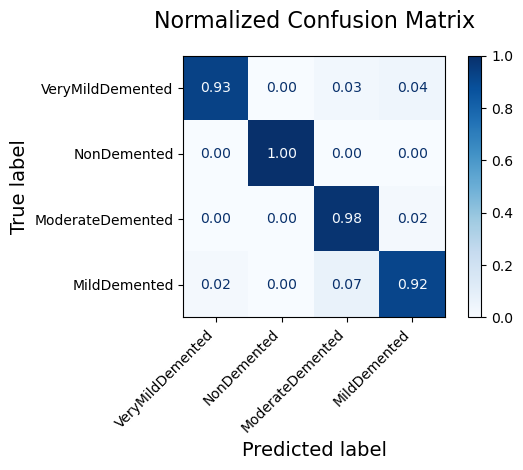

In [14]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_normalized_confusion_matrix(testloader, model, class_names, device, model_name)

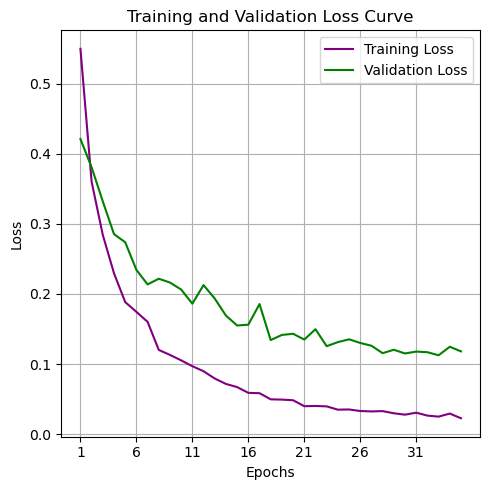

In [16]:
utils_funcs.plot_loss_curve(epoch_train_losses, epoch_validation_losses, num_epochs, model_name)

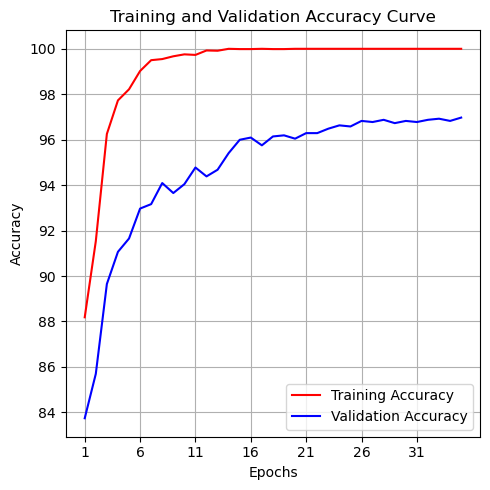

In [17]:
utils_funcs.plot_accuracy_curve(epoch_train_accuracies, epoch_validation_accuracies, num_epochs, model_name)